## 题目1：航空公司客户价值分析

### 题目描述

您是某航空公司的初级数据分析师，公司希望通过分析客户的历史飞行数据来识别高价值客户，以便进行精准营销。现在您得到了一份名为 `flight_data.csv` 的模拟数据集。该数据集包含了客户的以下信息：

- `customer_id`: 客户唯一标识符
- `flight_date`: 飞行日期（格式：YYYY-MM-DD）
- `flight_number`: 航班号
- `origin`: 出发地
- `destination`: 目的地
- `fare`: 票价（可能包含非数字字符，如 'USD'）
- `cabin_class`: 舱位等级（例如：Economy, Business, First）
- `distance_miles`: 飞行距离（英里）

请您使用 Python 对这份数据进行以下分析，以实现客户价值评估：


### 目标要求：

1.  **数据加载与概览**：
    *   加载 `flight_data.csv` 文件到 Pandas DataFrame。
    *   显示数据集的前5行、数据类型和基本统计信息。

2.  **数据清洗与预处理**：
    *   **处理 `fare` 字段**：
        *   去除 'USD ' 前缀（如果存在）。
        *   将 `fare` 列转换为数值类型。
        *   使用该列的**中位数**填充缺失值。
    *   **处理 `flight_number` 字段**：
        *   将缺失值（`None`）填充为 'UNKNOWN'。
    *   **处理 `cabin_class` 字段**：
        *   将空字符串（`''`）替换为 'Economy' (假设空字符串代表经济舱)。
    *   **处理 `distance_miles` 字段**：
        *   将小于等于 0 的值替换为该列的**平均值**。
    *   **处理 `flight_date` 字段**：
        *   确保其为 datetime 类型。

3.  **计算 RFM 指标**：
    为了评估客户价值，我们需要计算每个客户的 RFM (Recency, Frequency, Monetary) 指标。
    *   **Recency (近度)**：
        *   计算每个客户**距离最近一次飞行日期**的天数。以数据集中的最大飞行日期作为“当前日期”。
    *   **Frequency (频度)**：
        *   计算每个客户**总的飞行次数**。
    *   **Monetary (价值)**：
        *   计算每个客户**总的票价花费**。

    请将这些 RFM 指标合并到一个新的 DataFrame 中，其中包含 `customer_id`, `Recency`, `Frequency`, `Monetary`。

4.  **客户分群**：
    基于 RFM 指标，对客户进行简单的分群。
    *   将 `Recency`, `Frequency`, `Monetary` 各自划分为 3 个等级 (1 到 3，等级越高代表表现越好)。
        *   `Recency`: 值越小越好 (最近飞行)，因此等级划分规则为：最小 33% 设为 3，中间 33% 设为 2，最大 33% 设为 1。
        *   `Frequency`: 值越大越好 (飞行次数多)，因此等级划分规则为：最小 33% 设为 1，中间 33% 设为 2，最大 33% 设为 3。
        *   `Monetary`: 值越大越好 (花费金额高)，因此等级划分规则与 Frequency 相同。
    *   创建一个新的列 `RFM_Score`，其值为 `Recency_Score` * 100 + `Frequency_Score` * 10 + `Monetary_Score`。
    *   根据 `RFM_Score` 对客户进行分群，例如：
        *   `RFM_Score` >= 323: "高价值客户"
        *   `RFM_Score` >= 222 and `RFM_Score` < 323: "中价值客户"
        *   `RFM_Score` < 222: "低价值客户"
    *   统计各客户群体的数量。

### 模拟数据

为了方便练习，使用以下代码创建 `flight_data.csv` 文件：


In [8]:
import pandas as pd
import numpy as np

# 模拟数据
np.random.seed(42)
num_customers = 500
num_flights = 5000

customer_ids = [f'C_{i:04d}' for i in range(1, num_customers + 1)]
flight_dates = pd.to_datetime('2022-01-01') + pd.to_timedelta(np.random.randint(0, 365, num_flights), unit='D')
flight_numbers = np.array([f'AA{np.random.randint(100, 999)}' for _ in range(num_flights)])  # Convert to numpy array
origins = np.random.choice(['JFK', 'LAX', 'ORD', 'DFW', 'ATL', 'DEN', 'SFO', 'CLT'], num_flights)
destinations = np.random.choice(['JFK', 'LAX', 'ORD', 'DFW', 'ATL', 'DEN', 'SFO', 'CLT'], num_flights)
fares = np.random.randint(50, 2000, num_flights).astype(object)
cabin_classes = np.random.choice(['Economy', 'Business', 'First'], num_flights, p=[0.7, 0.2, 0.1])
distance_miles = np.random.randint(200, 5000, num_flights)

# Introduce some missing values and dirty data
fares[np.random.choice(num_flights, 50, replace=False)] = np.nan
fares[np.random.choice(num_flights, 30, replace=False)] = 'USD ' + fares[np.random.choice(num_flights, 30, replace=False)].astype(str)
flight_numbers[np.random.choice(num_flights, 20, replace=False)] = np.nan  # This will now work
cabin_classes[np.random.choice(num_flights, 40, replace=False)] = ''
distance_miles[np.random.choice(num_flights, 60, replace=False)] = -100

data = pd.DataFrame({
    'customer_id': np.random.choice(customer_ids, num_flights, replace=True),
    'flight_date': flight_dates,
    'flight_number': flight_numbers,
    'origin': origins,
    'destination': destinations,
    'fare': fares,
    'cabin_class': cabin_classes,
    'distance_miles': distance_miles
})

data.to_csv(r'csv\flight_data.csv', index=False)
print("flight_data.csv created successfully!")

flight_data.csv created successfully!


### 答题

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

1.  **数据加载与概览**：
    *   加载 `flight_data.csv` 文件到 Pandas DataFrame。
    *   显示数据集的前5行、数据类型和基本统计信息。

In [31]:
df = pd.read_csv(r"csv\flight_data.csv")

print(f"数据前 5 行:\n{df.head()}\n")
print(f"数据类型:\n{df.dtypes}\n")
print(f"数据基本统计:\n{df.describe()}\n")


数据前 5 行:
  customer_id flight_date flight_number origin destination  fare cabin_class  \
0      C_0335  2022-04-13         AA961    ORD         JFK   443     Economy   
1      C_0147  2022-12-15         AA667    JFK         JFK  1859     Economy   
2      C_0102  2022-09-28         AA159    ORD         JFK   839    Business   
3      C_0288  2022-04-17         AA749    ORD         DEN   644       First   
4      C_0313  2022-03-13         AA138    SFO         SFO   107     Economy   

   distance_miles  
0            4980  
1            4856  
2            4418  
3            2865  
4             615  

数据类型:
customer_id       object
flight_date       object
flight_number     object
origin            object
destination       object
fare              object
cabin_class       object
distance_miles     int64
dtype: object

数据基本统计:
       distance_miles
count     5000.000000
mean      2554.478400
std       1395.315114
min       -100.000000
25%       1354.750000
50%       2590.000000
75%   

2.  **数据清洗与预处理**：
    *   **处理 `fare` 字段**：
        *   去除 'USD ' 前缀（如果存在）。
        *   将 `fare` 列转换为数值类型。
        *   使用该列的**中位数**填充缺失值。
    *   **处理 `flight_number` 字段**：
        *   将缺失值（`None`）填充为 'UNKNOWN'。
    *   **处理 `cabin_class` 字段**：
        *   将空字符串（`''`）替换为 'Economy' (假设空字符串代表经济舱)。
    *   **处理 `distance_miles` 字段**：
        *   将小于等于 0 的值替换为该列的**平均值**。
    *   **处理 `flight_date` 字段**：
        *   确保其为 datetime 类型。

In [32]:
df['fare'] = df['fare'].replace('USD ', "", regex=True).str.strip().astype(float)

df['fare'] = df['fare'].fillna(df['fare'].median())

In [33]:
df['flight_number'] = df['flight_number'].fillna("UNKNOWN")

In [36]:
df['cabin_class'] = df['cabin_class'].replace('', 'Economy', regex=True)

In [53]:
mean_distance = df[df['distance_miles'] > 0]['distance_miles'].mean()
# 推荐使用
# mean_distance = df.loc[df['distance_miles'] > 0, 'distance_miles'].mean()

df['distance_miles'] = df['distance_miles'].apply(lambda x: x if x > 0 else mean_distance)
print(f"distance_miles 异常值处理完成，小于等于0的值替换为平均值: {mean_distance:.2f}")

distance_miles 异常值处理完成，小于等于0的值替换为平均值: 2586.72


3.  **计算 RFM 指标**：
    为了评估客户价值，我们需要计算每个客户的 RFM (Recency, Frequency, Monetary) 指标。
    *   **Recency (近度)**：Recency衡量的是客户最近一次飞行距离现在有多久
        *   计算每个客户**距离最近一次飞行日期**的天数。以数据集中的最大飞行日期作为“当前日期”。
    *   **Frequency (频度)**：
        *   计算每个客户**总的飞行次数**。
    *   **Monetary (价值)**：
        *   计算每个客户**总的票价花费**。

    请将这些 RFM 指标合并到一个新的 DataFrame 中，其中包含 `customer_id`, `Recency`, `Frequency`, `Monetary`。

In [61]:
current_date = df['flight_date'].max()

def recency(data):

    global current_date
    max_date = data.max()
    return (current_date - max_date).days


# df.groupby('customer_id').agg({
#     "flight_date": recency,
#     "flight_number": "count",
#     "fare": "sum"
# })

df_rfm = df.groupby('customer_id').agg(R=('flight_date', recency),
                              F=('flight_number', 'count'),
                              M=('fare', 'sum')
                              )

print(df_rfm)



              R   F        M
customer_id                 
C_0001       40  11   9879.0
C_0002       28   6   5815.0
C_0003        1  12  10200.0
C_0004       55   4   3119.0
C_0005       24   9  10639.0
...          ..  ..      ...
C_0496       90   4   4774.0
C_0497       50  15  12357.0
C_0498       50  13  11225.0
C_0499       10  14  12194.0
C_0500       37  12  14271.0

[500 rows x 3 columns]


4.  **客户分群**：
    基于 RFM 指标，对客户进行简单的分群。
    *   将 `Recency`, `Frequency`, `Monetary` 各自划分为 3 个等级 (1 到 3，等级越高代表表现越好)。
        *   `Recency`: 值越小越好 (最近飞行)，因此等级划分规则为：最小 33% 设为 3，中间 33% 设为 2，最大 33% 设为 1。
        *   `Frequency`: 值越大越好 (飞行次数多)，因此等级划分规则为：最小 33% 设为 1，中间 33% 设为 2，最大 33% 设为 3。
        *   `Monetary`: 值越大越好 (花费金额高)，因此等级划分规则与 Frequency 相同。
    *   创建一个新的列 `RFM_Score`，其值为 `Recency_Score` * 100 + `Frequency_Score` * 10 + `Monetary_Score`。
    *   根据 `RFM_Score` 对客户进行分群，例如：
        *   `RFM_Score` >= 323: "高价值客户"
        *   `RFM_Score` >= 222 and `RFM_Score` < 323: "中价值客户"
        *   `RFM_Score` < 222: "低价值客户"
    *   统计各客户群体的数量。

In [63]:
df_rfm['R_score'] = pd.qcut(df_rfm['R'], q=3, labels=[3, 2, 1], duplicates='drop').astype(int)

df_rfm['F_score'] = pd.qcut(df_rfm['F'], q=3, labels=[1, 2, 3], duplicates='drop').astype(int)
df_rfm['M_score'] = pd.qcut(df_rfm['M'], q=3, labels=[1, 2, 3], duplicates='drop').astype(int)

df_rfm['RFM_Score'] = df_rfm['R_score'] * 100 + df_rfm['F_score'] * 10 + df_rfm['M_score']
print(df_rfm)


              R   F        M  R_score  F_score  M_score  RFM_Score
customer_id                                                       
C_0001       40  11   9879.0        2        2        2        222
C_0002       28   6   5815.0        2        1        1        211
C_0003        1  12  10200.0        3        3        2        332
C_0004       55   4   3119.0        1        1        1        111
C_0005       24   9  10639.0        2        2        2        222
...          ..  ..      ...      ...      ...      ...        ...
C_0496       90   4   4774.0        1        1        1        111
C_0497       50  15  12357.0        1        3        3        133
C_0498       50  13  11225.0        1        3        2        132
C_0499       10  14  12194.0        3        3        3        333
C_0500       37  12  14271.0        2        3        3        233

[500 rows x 7 columns]


In [66]:
def uer_level(rfm_score):
    if rfm_score >= 333:
        return '高价值客户'
    elif 222 <= rfm_score < 333:
        return '中价值客户'
    else:
        return '低价值客户'
    
df_rfm['User_Level'] = df_rfm['RFM_Score'].apply(uer_level)
print(df_rfm)

              R   F        M  R_score  F_score  M_score  RFM_Score User_Level
customer_id                                                                  
C_0001       40  11   9879.0        2        2        2        222      中价值客户
C_0002       28   6   5815.0        2        1        1        211      低价值客户
C_0003        1  12  10200.0        3        3        2        332      中价值客户
C_0004       55   4   3119.0        1        1        1        111      低价值客户
C_0005       24   9  10639.0        2        2        2        222      中价值客户
...          ..  ..      ...      ...      ...      ...        ...        ...
C_0496       90   4   4774.0        1        1        1        111      低价值客户
C_0497       50  15  12357.0        1        3        3        133      低价值客户
C_0498       50  13  11225.0        1        3        2        132      低价值客户
C_0499       10  14  12194.0        3        3        3        333      高价值客户
C_0500       37  12  14271.0        2        3        3        2

# 题目2：Word 文档自动化处理 - 项目报告模板填充

### 题目描述：

你是一家大型咨询公司的实习数据分析师。

公司有一份标准的项目报告模板（Project_Report_Template.docx），这份模板包含一些占位符，需要根据具体的项目信息进行替换。

你的任务是编写一个 Python 脚本，读取这份模板，根据提供的项目数据，自动填充并生成一份新的、完整的项目报告。

目标要求：
- 读取模板并替换：
    1. 读取 Project_Report_Template.docx。
    2. 遍历文档中的所有段落（Paragraph）和表格（Table）单元格，查找并替换 placeholder_map 中定义的所有占位符。
    3. 替换占位符：
        - 若占位符出现在段落文本中，直接替换。
        - 若占位符出现在表格单元格中，需要先获取单元格的文本，替换后再设置回单元格。
    4. 保留格式：在替换文本时，要注意保留原段落或单元格的格式，包括字体、大小、加粗、斜体等。

生成新文档：将填充完毕的报告保存为 Filled_Project_Report.docx。

模拟数据

In [ ]:
project_data = {
    "COMPANY_NAME": "ABC 数据咨询",
    "PROJECT_Slogan": "数据驱动未来", # 这是一个额外信息，需要您自行决定处理方式或忽略
    "PROJECT_TITLE": "电商客户行为分析报告",
    "PROJECT_MANAGER": "张三",
    "REPORT_DATE": "2023-10-26",
    "CUSTOMER_NAME": "XYZ 电商平台",
}


analysis_data = {
    "TOTAL_ORDERS": 12586,
    "AVERAGE_ORDER_AMOUNT": 345.78,
    "HIGH_VALUE_CUSTOMER_PERCENTAGE": 25.3
}

recommendations_text = "通过优化商品推荐算法和提升用户互动，可以进一步提高客户留存率和复购率。"

placeholder_map = {
    "[公司名称]": project_data["COMPANY_NAME"],
    "[PROJECT_NAME]": project_data["PROJECT_TITLE"],
    "[PROJECT_MANAGER]": project_data["PROJECT_MANAGER"],
    "[REPORT_DATE]": project_data["REPORT_DATE"],
    "[CUSTOMER_NAME]": project_data["CUSTOMER_NAME"],
    "[PROJECT_PURPOSE]": "深入理解客户购物习惯，识别高价值客户群体，并为精准营销提供数据支持", # 这个占位符在模板中有，但未在project_data中
    "[TOTAL_ORDERS]": analysis_data["TOTAL_ORDERS"],
    "[AVERAGE_ORDER_AMOUNT]": f"{analysis_data['AVERAGE_ORDER_AMOUNT']:.2f} 元", # 格式化输出
    "[HIGH_VALUE_CUSTOMER_PERCENTAGE]": analysis_data["HIGH_VALUE_CUSTOMER_PERCENTAGE"],
    "[RECOMMENDATIONS]": recommendations_text
}


读取 Project_Report_Template.docx

In [3]:
from docx import Document

In [4]:
doc = Document(r'docx\Project_Report_Template.docx')

2. 遍历文档中的所有段落（Paragraph）和表格（Table）单元格，查找并替换 placeholder_map 中定义的所有占位符。
3. 替换占位符：
    - 若占位符出现在段落文本中，直接替换。
    - 若占位符出现在表格单元格中，需要先获取单元格的文本，替换后再设置回单元格。
4. 保留格式：在替换文本时，要注意保留原段落或单元格的格式，包括字体、大小、加粗、斜体等。

In [ ]:
for para in doc.paragraphs:
    for run in para.runs:
        if ''

# 题目3：电商销售数据分析

**题目描述：**
你拿到了一份某电商平台近一年的销售数据 `sales_data.csv`。该数据集包含以下字段：
- `Order_ID`: 订单编号 (字符串)
- `Order_Date`: 下单日期 (格式为 `DD-MM-YYYY`)
- `Category`: 商品类别 (字符串，如 `Electronics`, `Clothing`, `Home & Kitchen`)
- `Product_Name`: 商品名称 (字符串)
- `Quantity`: 销售数量 (整数)
- `Unit_Price`: 商品单价 (浮点数，单位：美元)
- `Customer_ID`: 客户ID (字符串)

**请注意，原始数据可能存在以下问题：**
1.  日期格式不统一。
2.  可能存在重复的记录。
3.  `Quantity` 或 `Unit_Price` 可能存在异常值（如负数或极大值）。
4.  部分字段可能存在缺失值（NaN）。

**你的任务是：**

1.  **数据加载与初步检查：**
    - 读取 `sales_data.csv` 文件。
    - 查看数据的基本信息（如 `.info()`, `.describe()`）和前5行内容。

2.  **数据清洗与预处理：**
    - **处理重复值：** 删除完全重复的行。
    - **处理缺失值：** 检查各列缺失值情况。对于 `Customer_ID` 的缺失，使用字符串 `"Unknown"` 填充。对于 `Quantity` 或 `Unit_Price` 的缺失，使用该列的中位数填充。
    - **日期格式化：** 将 `Order_Date` 列转换为 `datetime` 类型，格式为 `YYYY-MM-DD`。
    - **创建新特征：** 添加一列 `Total_Sales`，计算公式为 `Quantity * Unit_Price`。
    - **处理异常值：** 认为 `Total_Sales` <= 0 的记录为异常值，将其从数据集中删除。

3.  **数据分析与统计：**
    - 计算**总销售额**和**总订单数**。
    - 找出**销售额最高的前5个商品**（根据 `Product_Name` 分组汇总）。
    - 按 `Category` 分组，计算每个类别的**总销售额**和**平均订单价值（Average Order Value, AOV = 总销售额 / 总订单数）**。
    - 分析销售额的月度趋势。提取 `Order_Date` 的年份和月份，按年月分组计算月度总销售额。

4.  **数据可视化：**
    - 绘制一个图表，展示**不同商品类别的总销售额**（使用条形图或饼图）。
    - 绘制一个图表，展示**2023年月度销售额的变化趋势**（使用折线图）。
    - (**可选**) 绘制箱线图，查看各个商品类别中 `Total_Sales` 的分布情况，并分析哪些类别的销售额波动较大。

**目标：** 通过以上分析，清晰地展示销售数据的整体情况、关键指标以及趋势，为业务决策提供数据支持。

### 模拟数据生成

In [3]:
import pandas as pd
import numpy as np

# 设置随机种子以保证结果可重现
np.random.seed(42)

# 定义基础参数
num_records = 1000
categories = ['Electronics', 'Clothing', 'Home & Kitchen', 'Books', 'Sports']
products = {
    'Electronics': ['Smartphone X', 'Laptop Pro', 'Wireless Earbuds', 'Smart Watch', 'Tablet Lite'],
    'Clothing': ['Cotton T-Shirt', 'Denim Jeans', 'Winter Jacket', 'Running Shorts', 'Formal Shirt'],
    'Home & Kitchen': ['Coffee Maker', 'Blender', 'Cutlery Set', 'Desk Lamp', 'Yoga Mat'],
    'Books': ['Python Crash Course', 'Data Science Handbook', 'Cooking 101', 'History of Rome', 'Sci-Fi Novel'],
    'Sports': ['Basketball', 'Running Shoes', 'Yoga Mat', 'Water Bottle', 'Dumbbell Set']
}

# 1. 生成基本数据
data = {
    'Order_ID': [f'ORD_{i:04d}' for i in range(1, num_records + 1)],
    'Order_Date': np.random.choice(pd.date_range('2023-01-01', '2023-12-31'), num_records),
    'Category': np.random.choice(categories, num_records),
    'Quantity': np.random.randint(1, 11, num_records), # 数量介于1到10
    'Unit_Price': np.round(np.random.uniform(10, 500, num_records), 2), # 单价介于10到500
    'Customer_ID': [f'CUST_{np.random.randint(1000, 9999)}' for _ in range(num_records)]
}

# 根据类别为产品名称赋值
data['Product_Name'] = [np.random.choice(products[cat]) for cat in data['Category']]

# 创建初始DataFrame
df = pd.DataFrame(data)

# 2. 故意引入数据问题

# 问题1: 创建一些完全重复的行 (约2%)
duplicate_rows = df.sample(frac=0.02, random_state=42)
df = pd.concat([df, duplicate_rows], ignore_index=True)

# 问题2: 打乱日期格式 (约30%的日期格式为 DD-MM-YYYY，其余为 MM/DD/YYYY)
date_mask = np.random.rand(len(df)) < 0.3
df.loc[date_mask, 'Order_Date'] = df.loc[date_mask, 'Order_Date'].dt.strftime('%d-%m-%Y')
df.loc[~date_mask, 'Order_Date'] = df.loc[~date_mask, 'Order_Date'].dt.strftime('%m/%d/%Y')

# 插入几个无效日期字符串
df['Order_Date'] = df['Order_Date'].astype(str)
invalid_date_indices = df.sample(n=5, random_state=42).index
df.loc[invalid_date_indices, 'Order_Date'] = ['31-02-2023', '13/13/2023', '00-01-2023', '02/30/2023', 'InvalidDate']

# 问题3: 引入缺失值 (NaN)
# Customer_ID 缺失约5%
cust_nan_indices = df.sample(frac=0.05, random_state=1).index
df.loc[cust_nan_indices, 'Customer_ID'] = np.nan

# Quantity 缺失约3%
qty_nan_indices = df.sample(frac=0.03, random_state=2).index
df.loc[qty_nan_indices, 'Quantity'] = np.nan

# Unit_Price 缺失约3%
price_nan_indices = df.sample(frac=0.03, random_state=3).index
df.loc[price_nan_indices, 'Unit_Price'] = np.nan

# 问题4: 引入异常值
# 将一些Quantity设置为负值或0 (约2%)
neg_qty_indices = df.sample(frac=0.02, random_state=4).index
df.loc[neg_qty_indices, 'Quantity'] = np.random.randint(-5, 1, len(neg_qty_indices))

# 将一些Unit_Price设置为极高的值 (约1%)
high_price_indices = df.sample(frac=0.01, random_state=5).index
df.loc[high_price_indices, 'Unit_Price'] = np.random.uniform(10000, 50000, len(high_price_indices))

# 3. 再次打乱数据行的顺序
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# 4. 保存到CSV文件
df.to_csv(r'csv\sales_data.csv', index=False)

print(r"模拟数据已生成并保存到 'csv\sales_data.csv'")
print(f"数据集形状: {df.shape}")
print("\n前5行数据预览:")
print(df.head())
print("\n各列缺失值统计:")
print(df.isnull().sum())


模拟数据已生成并保存到 'csv\sales_data.csv'
数据集形状: (1020, 7)

前5行数据预览:
   Order_ID   Order_Date        Category  Quantity  Unit_Price Customer_ID  \
0  ORD_0524   31-02-2023           Books       4.0      117.37   CUST_8545   
1  ORD_0603   13/13/2023     Electronics       4.0      424.47   CUST_9848   
2  ORD_0527   00-01-2023  Home & Kitchen      10.0       96.29   CUST_7589   
3  ORD_0032   02/30/2023     Electronics       5.0      224.88   CUST_5177   
4  ORD_0617  InvalidDate           Books       6.0      440.95   CUST_8984   

            Product_Name  
0            Cooking 101  
1            Tablet Lite  
2            Cutlery Set  
3            Smart Watch  
4  Data Science Handbook  

各列缺失值统计:
Order_ID         0
Order_Date       0
Category         0
Quantity        31
Unit_Price      31
Customer_ID     51
Product_Name     0
dtype: int64


In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

数据加载与初步检查：

- 读取 sales_data.csv 文件。
- 查看数据的基本信息（如 .info(), .describe()）和前5行内容

In [94]:
df = pd.read_csv(r'csv\sales_data.csv')
print(f"数据的统计信息: \n {df.describe()}")
print(f"数据的前 5 行: \n {df.head(5)}")

数据的统计信息: 
          Quantity    Unit_Price
count  989.000000    989.000000
mean     5.373104    587.861192
std      2.990424   3422.933372
min     -5.000000     10.220000
25%      3.000000    143.030000
50%      5.000000    270.480000
75%      8.000000    387.660000
max     10.000000  48433.176683
数据的前 5 行: 
    Order_ID   Order_Date        Category  Quantity  Unit_Price Customer_ID  \
0  ORD_0524   31-02-2023           Books       4.0      117.37   CUST_8545   
1  ORD_0603   13/13/2023     Electronics       4.0      424.47   CUST_9848   
2  ORD_0527   00-01-2023  Home & Kitchen      10.0       96.29   CUST_7589   
3  ORD_0032   02/30/2023     Electronics       5.0      224.88   CUST_5177   
4  ORD_0617  InvalidDate           Books       6.0      440.95   CUST_8984   

            Product_Name  
0            Cooking 101  
1            Tablet Lite  
2            Cutlery Set  
3            Smart Watch  
4  Data Science Handbook  


数据清洗与预处理：

- 处理重复值： 删除完全重复的行。
- 处理缺失值： 检查各列缺失值情况。对于 Customer_ID 的缺失，使用字符串 "Unknown" 填充。对于 Quantity 或 Unit_Price 的缺失，使用该列的中位数填充。
- 日期格式化： 将 Order_Date 列转换为 datetime 类型，格式为 YYYY-MM-DD。
- 创建新特征： 添加一列 Total_Sales，计算公式为 Quantity * Unit_Price。
- 处理异常值： 认为 Total_Sales <= 0 的记录为异常值，将其从数据集中删除。

In [ ]:
df = df.drop_duplicates()

print(f"各列缺失情况如下: \n{df.isna().sum()}")

df['Customer_ID'] = df['Customer_ID'].fillna("Unknown")
df = df.fillna({
    "Quantity": df['Quantity'].median(),
    "Unit_Price": df['Unit_Price'].median()
})

df['Order_Date'] = pd.to_datetime(df['Order_Date'], format="%Y-%m-%d", errors="coerce")

df['Total_Sales'] = df['Quantity'] * df['Unit_Price']

df = df.drop(df[df["Total_Sales"] <= 0].index)


各列缺失情况如下: 
Order_ID         0
Order_Date       0
Category         0
Quantity        31
Unit_Price      31
Customer_ID     51
Product_Name     0
dtype: int64
(986, 8)


# 日期解析：尝试多种格式，避免指定单一格式
df['Order_Date'] = pd.to_datetime(df['Order_Date'], errors='coerce', dayfirst=True)
# 检查日期解析后的缺失值（NaT）
print(f"\n日期解析后 NaT 数量: {df['Order_Date'].isna().sum()}")
# 删除日期无效的行
df = df.dropna(subset=['Order_Date'])
print(f"删除无效日期后数据形状: {df.shape}")

In [53]:
print(f"各列缺失情况如下: \n{df.isna().sum()}")

各列缺失情况如下: 
Order_ID        0
Order_Date      5
Category        0
Quantity        0
Unit_Price      0
Customer_ID     0
Product_Name    0
Total_Sales     0
dtype: int64


 **数据分析与统计：**
    
   - 计算**总销售额**和**总订单数**。
   - 找出**销售额最高的前5个商品**（根据 `Product_Name` 分组汇总）。
   - 按 `Category` 分组，计算每个类别的**总销售额**和**平均订单价值（Average Order Value, AOV = 总销售额 / 总订单数）**。
   - 分析销售额的月度趋势。提取 `Order_Date` 的年份和月份，按年月分组计算月度总销售额。

In [98]:
print(df['Total_Sales'].sum())
print(df['Order_ID'].count())

top_5 = df.groupby("Product_Name")['Total_Sales'].sum().sort_values(ascending=False).head(5)
print(top_5)


# def AOV(data:pd.DataFrame):
#     return (data['Total_Sales'].sum() / data['Order_ID'].count()).round(2)

tmp_df = df.groupby("Category", as_index=True).agg({
    "Total_Sales": "sum",
    "Order_ID": "count"
})
tmp_df['AOV'] = (tmp_df['Total_Sales'] / tmp_df["Order_ID"]).round(2)
print(tmp_df)


2618612.3983192127
986
Product_Name
Water Bottle     278578.426222
Yoga Mat         278503.449239
Winter Jacket    237851.440390
Cooking 101      227860.873562
Dumbbell Set     201218.764452
Name: Total_Sales, dtype: float64
                  Total_Sales  Order_ID      AOV
Category                                        
Books           503188.860245       184  2734.72
Clothing        521237.330589       199  2619.28
Electronics     297855.910000       207  1438.92
Home & Kitchen  467540.297571       190  2460.74
Sports          828789.999914       206  4023.25


In [97]:
data_df = df.copy()
# print(data_df[~data_df['Order_Date'].isna()])

data_df['Year'] = data_df['Order_Date'].dt.year
data_df['Month'] = data_df['Order_Date'].dt.month

month_sales = data_df.groupby(["Year", "Month"], as_index=True)["Total_Sales"].agg("sum")
print(month_sales)

Year    Month
2023.0  1.0      253817.530390
        2.0      134696.230000
        3.0      267206.823562
        4.0      162630.910000
        5.0      342830.534652
        6.0      256950.822812
        7.0      120213.966683
        8.0      325846.199053
        9.0      390200.391167
        10.0      93420.940000
        11.0     121997.640000
        12.0     141900.050000
Name: Total_Sales, dtype: float64


**数据可视化：**

- 绘制一个图表，展示**不同商品类别的总销售额**（使用条形图或饼图）。
- 绘制一个图表，展示**2023年月度销售额的变化趋势**（使用折线图）。
- (**可选**) 绘制箱线图，查看各个商品类别中 `Total_Sales` 的分布情况，并分析哪些类别的销售额波动较大。

In [101]:
tmp_df = tmp_df.reset_index(names="Category")


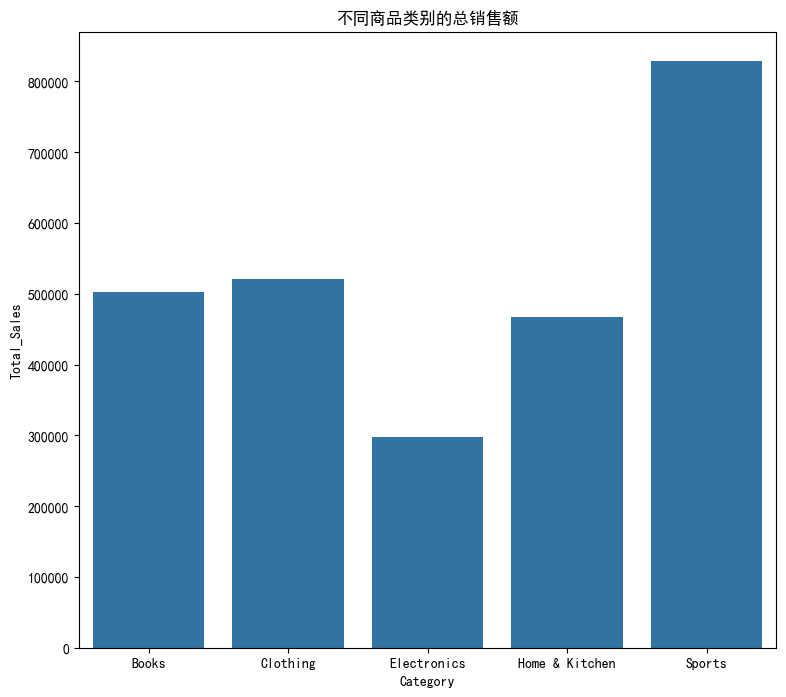

In [102]:
fig = plt.figure(figsize=(9, 8))

sns.barplot(data=tmp_df, x='Category', y='Total_Sales')

plt.title("不同商品类别的总销售额")
plt.show()

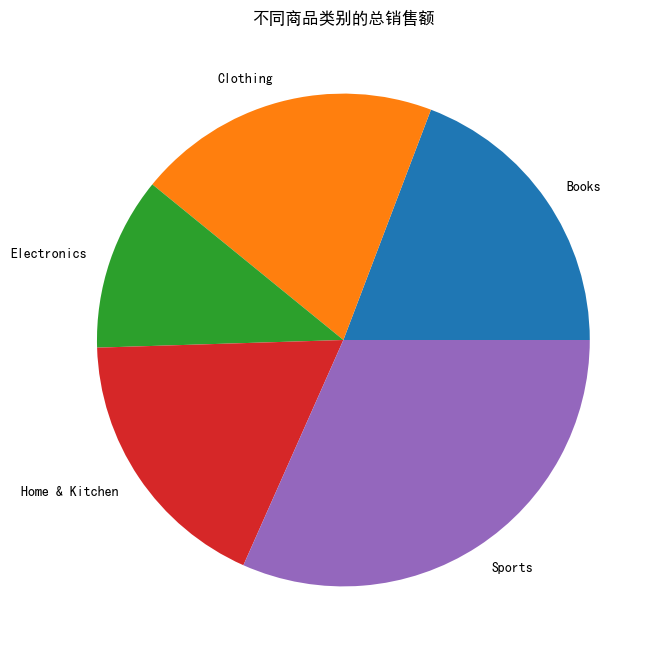

In [103]:
fig = plt.figure(figsize=(9, 8))

plt.pie(x=tmp_df['Total_Sales'], labels=tmp_df['Category'])

plt.title("不同商品类别的总销售额")
plt.show()

In [104]:
# 2023年月度销售额的变化趋势

month_sales = month_sales.reset_index()
print(month_sales)

      Year  Month    Total_Sales
0   2023.0    1.0  253817.530390
1   2023.0    2.0  134696.230000
2   2023.0    3.0  267206.823562
3   2023.0    4.0  162630.910000
4   2023.0    5.0  342830.534652
5   2023.0    6.0  256950.822812
6   2023.0    7.0  120213.966683
7   2023.0    8.0  325846.199053
8   2023.0    9.0  390200.391167
9   2023.0   10.0   93420.940000
10  2023.0   11.0  121997.640000
11  2023.0   12.0  141900.050000


<Figure size 900x1200 with 0 Axes>

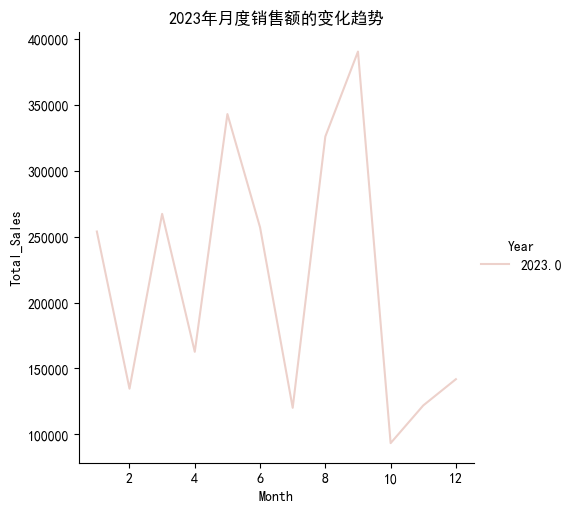

In [105]:
fig = plt.figure(figsize=(9, 12))

sns.relplot(data=month_sales, x='Month', y="Total_Sales", hue="Year", kind='line')

plt.title("2023年月度销售额的变化趋势")
plt.show()

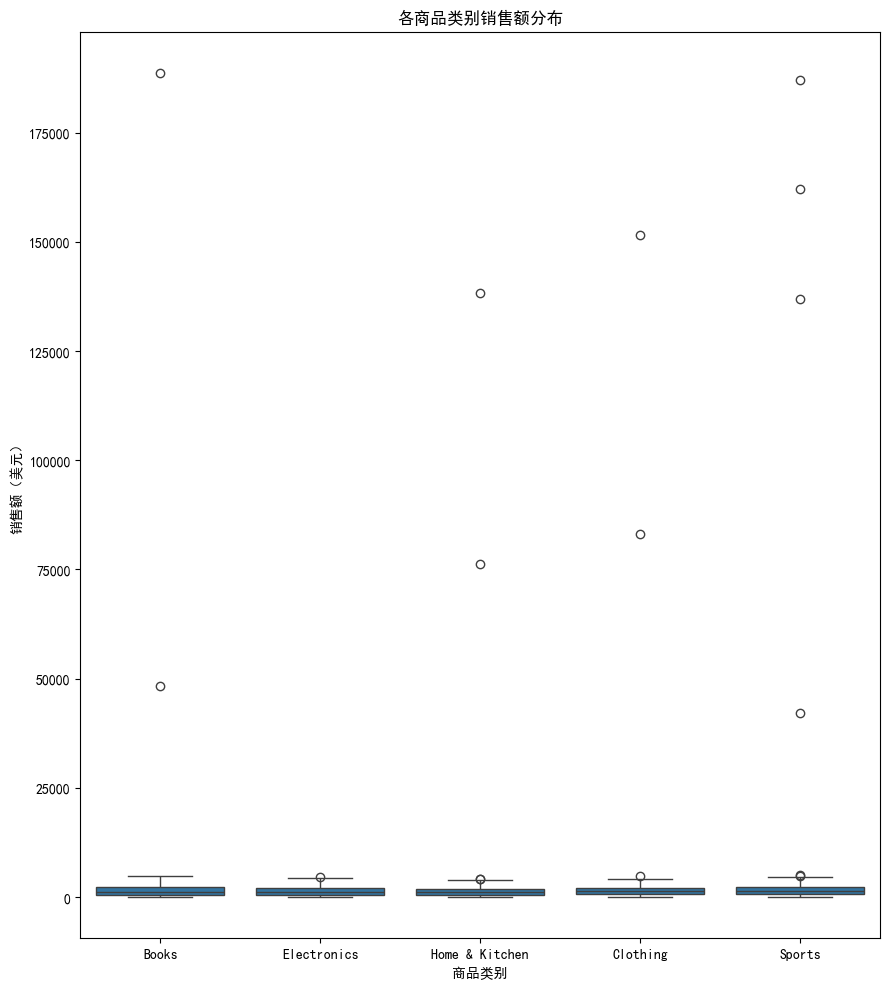

In [109]:
plt.figure(figsize=(9, 10))
sns.boxplot(data=df, x='Category', y='Total_Sales')
plt.title('各商品类别销售额分布')
plt.xlabel('商品类别')
plt.ylabel('销售额（美元）')
plt.tight_layout()
plt.show()